In [1]:
#!conda activate tensorflow
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("Reportes/Nuevos/datos_abiertos_covid19/COVID19_Mexico.csv", sep=',', index_col=0)
data.head(7)

,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
FECHA_ACTUALIZACION,,,,,,,,,,,,,,,,,,,,,
2020-04-19,09e8dc,2,9,15,1,15,15,37.0,2,2020-04-09,...,2,2,2,2,2,1,99,99,97,1
2020-04-19,1dd782,2,12,9,1,15,9,3.0,1,2020-04-16,...,2,1,2,2,2,2,99,99,97,97
2020-04-19,0efbaf,2,9,28,2,16,28,32.0,1,2020-04-06,...,2,2,2,2,1,1,99,99,97,97
2020-04-19,0e8ab4,2,12,9,2,99,9,13.0,1,2020-04-17,...,2,2,2,2,1,3,99,99,97,97
2020-04-19,013a6c,1,3,15,2,15,15,106.0,1,2020-04-16,...,2,1,2,2,1,3,99,99,97,97
2020-04-19,091a48,1,12,15,2,15,15,31.0,2,2020-04-06,...,2,2,2,2,2,2,99,99,97,2
2020-04-19,1a5595,2,12,9,2,99,9,8.0,1,2020-04-15,...,2,2,2,2,1,2,99,99,97,97


In [3]:
print(data.columns)
print(data.shape)
registers = data.shape[0]
print(registers)

Index(['ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC',
       'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')
(49570, 34)
49570


In [4]:
data['FECHA_INGRESO'] = pd.to_datetime(data['FECHA_INGRESO'], format='%Y/%m/%d')
data['FECHA_SINTOMAS'] = pd.to_datetime(data['FECHA_SINTOMAS'], format='%Y/%m/%d')

data['STATUS'] = ["VIVO" if value=='9999-99-99' else "FALLECIDO" for value in data['FECHA_DEF']]

data['FECHA_DEF'] = data['FECHA_DEF'].replace('9999-99-99',np.NaN)
data['FECHA_DEF'] = pd.to_datetime(data['FECHA_DEF'], format='%Y/%m/%d')

#data['FECHA_DEF'].replace('9999-99-99',np.NaN)
#pd.to_datetime(data["FECHA_DEF"], format='%d/%m/%Y')
#data.isnull().any()
#data['FECHA_DEF'] = data['FECHA_DEF'] == '9999-99-99' ? '' : data['FECHA_DEF']

In [5]:
xl_file = pd.ExcelFile("Reportes/Nuevos/diccionario_datos_covid19/Catalogos_0412.xlsx")
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

In [6]:
origen = dfs['Catálogo ORIGEN'].set_index('CLAVE').to_dict()['DESCRIPCIÓN']
sector = dfs['Catálogo SECTOR'].set_index('CLAVE').to_dict()['DESCRIPCIÓN']
sexo = dfs['Catálogo SEXO'].set_index('CLAVE').to_dict()['DESCRIPCIÓN']
tipo_paciente = dfs['Catálogo TIPO_PACIENTE'].set_index('CLAVE').to_dict()['DESCRIPCIÓN']
si_no = dfs['Catálogo SI_NO'].set_index('CLAVE').to_dict()['DESCRIPCIÓN']
nacionalidad = dfs['Catálogo NACIONALIDAD'].set_index('CLAVE').to_dict()['DESCRIPCIÓN']
resultado = dfs['Catálogo RESULTADO'][1:].set_index('Unnamed: 0').to_dict()['Unnamed: 1']
entidades = dfs['Catálogo de ENTIDADES'].set_index('CLAVE_ENTIDAD')['ABREVIATURA']
municipios = dfs['Catálogo MUNICIPIOS'].set_index(['CLAVE_ENTIDAD','CLAVE_MUNICIPIO']).to_dict()['MUNICIPIO']

In [7]:
#result = list(data[['ENTIDAD_RES','MUNICIPIO_RES']].to_records(index=False))

def replace_touple(df, col, dicc, colOut):
    salida = []
    salida = list()
    for key1, key2 in df[col]:
        if (key1,key2) in dicc:
            salida.append(dicc[(key1,key2)])
        else:
            salida.append(np.NaN)
       
    df[colOut] = salida

#tmp = [v in municipios for v in dataf['ENTIDAD_MUNICIPIO_RES']] 
#dataf.loc[tmp]

#dataf['ENTIDAD_MUNICIPIO_RES'].mask(dataf['ENTIDAD_MUNICIPIO_RES'] == (15,37), (1,1)), inplace=True)

In [8]:
dataf = data.copy()
dataf['ENTIDAD_MUNICIPIO_RES'] = list(zip(dataf['ENTIDAD_RES'], dataf['MUNICIPIO_RES']))
replace_touple(dataf, 'ENTIDAD_MUNICIPIO_RES', municipios, 'MUNICIPIO_RES')

dataf = dataf.replace({'ORIGEN': origen})
dataf = dataf.replace({'SECTOR': sector})
dataf = dataf.replace({'ENTIDAD_UM': entidades})
dataf = dataf.replace({'SEXO': sexo})
dataf = dataf.replace({'ENTIDAD_NAC': entidades})
dataf = dataf.replace({'ENTIDAD_RES': entidades})
dataf = dataf.replace({'TIPO_PACIENTE': tipo_paciente})
dataf = dataf.replace({'INTUBADO': si_no})
dataf = dataf.replace({'NEUMONIA': si_no})
dataf = dataf.replace({'NACIONALIDAD': nacionalidad})
dataf = dataf.replace({'EMBARAZO': si_no})
dataf = dataf.replace({'HABLA_LENGUA_INDI': si_no})
dataf = dataf.replace({'DIABETES': si_no})
dataf = dataf.replace({'EPOC': si_no})
dataf = dataf.replace({'ASMA': si_no})
dataf = dataf.replace({'INMUSUPR': si_no})
dataf = dataf.replace({'HIPERTENSION': si_no})
dataf = dataf.replace({'OTRA_CON': si_no})
dataf = dataf.replace({'CARDIOVASCULAR': si_no})
dataf = dataf.replace({'OBESIDAD': si_no})
dataf = dataf.replace({'RENAL_CRONICA': si_no})
dataf = dataf.replace({'TABAQUISMO': si_no})
dataf = dataf.replace({'OTRO_CASO': si_no})
dataf = dataf.replace({'RESULTADO': resultado})
dataf = dataf.replace({'MIGRANTE': si_no})
#dataf = dataf.replace({'PAIS_NACIONALIDAD': origen})
#dataf = dataf.replace({'PAIS_ORIGEN': origen})
dataf = dataf.replace({'UCI': si_no})

dataf['DIAS_INGRESO_SINTOMAS'] = (dataf['FECHA_INGRESO'] - dataf['FECHA_SINTOMAS']).dt.days
dataf['DIAS_SINTOMAS_DEF'] = (dataf['FECHA_DEF'] - dataf['FECHA_SINTOMAS']).dt.days

dataf.head()

,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,...,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,STATUS,ENTIDAD_MUNICIPIO_RES,DIAS_INGRESO_SINTOMAS,DIAS_SINTOMAS_DEF
FECHA_ACTUALIZACION,,,,,,,,,,,,,,,,,,,,,
2020-04-19,09e8dc,FUERA DE USMER,PRIVADA,MC,MUJER,MC,MC,HUIXQUILUCAN,HOSPITALIZADO,2020-04-09,...,NO,Positivo SARS-CoV-2,NO ESPECIFICADO,99,97,SI,VIVO,"(15, 37.0)",12,NaN
2020-04-19,1dd782,FUERA DE USMER,SSA,DF,MUJER,MC,DF,COYOACÁN,AMBULATORIO,2020-04-16,...,NO,No positivo SARS-CoV-2,NO ESPECIFICADO,99,97,NO APLICA,VIVO,"(9, 3.0)",14,NaN
2020-04-19,0efbaf,FUERA DE USMER,PRIVADA,TS,HOMBRE,MN,TS,REYNOSA,AMBULATORIO,2020-04-06,...,SI,Positivo SARS-CoV-2,NO ESPECIFICADO,99,97,NO APLICA,VIVO,"(28, 32.0)",2,NaN
2020-04-19,0e8ab4,FUERA DE USMER,SSA,DF,HOMBRE,NE,DF,XOCHIMILCO,AMBULATORIO,2020-04-17,...,SI,Resultado pendiente,NO ESPECIFICADO,99,97,NO APLICA,VIVO,"(9, 13.0)",2,NaN
2020-04-19,013a6c,USMER,ESTATAL,MC,HOMBRE,MC,MC,TOLUCA,AMBULATORIO,2020-04-16,...,SI,Resultado pendiente,NO ESPECIFICADO,99,97,NO APLICA,VIVO,"(15, 106.0)",2,NaN


In [9]:
print(dataf.columns)
dataq1 = dataf.query('RESULTADO =="Positivo SARS-CoV-2"')

fechas_serie = pd.date_range('20200217', periods=60, freq='D')
fechas_dataFrame = (fechas_serie.to_frame(name='Fecha'))

fechaSintomas = dataq1.groupby(['FECHA_SINTOMAS']).count()['DIAS_INGRESO_SINTOMAS'].to_frame(name='FECHA_SINTOMAS')
fechaIngreso = dataq1.groupby(['FECHA_INGRESO']).count()['DIAS_INGRESO_SINTOMAS'].to_frame(name='FECHA_INGRESO')
fechadef = dataq1.groupby(['FECHA_DEF']).count()['DIAS_SINTOMAS_DEF'].to_frame(name='FECHA_DEF')

fechas = fechas_dataFrame.join(fechaSintomas, lsuffix='si', rsuffix='_other')
fechas = fechas.join(fechaIngreso, lsuffix='_caller', rsuffix='_other')
fechas = fechas.join(fechadef, lsuffix='_caller', rsuffix='_other')

fechas = fechas.drop(['Fecha'], axis=1)

fechas.plot(kind='line', figsize=(15,10))

Index(['ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC',
       'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'STATUS',
       'ENTIDAD_MUNICIPIO_RES', 'DIAS_INGRESO_SINTOMAS', 'DIAS_SINTOMAS_DEF'],
      dtype='object')


Index(['ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC',
       'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'STATUS',
       'ENTIDAD_MUNICIPIO_RES', 'DIAS_INGRESO_SINTOMAS', 'DIAS_SINTOMAS_DEF'],
      dtype='object')


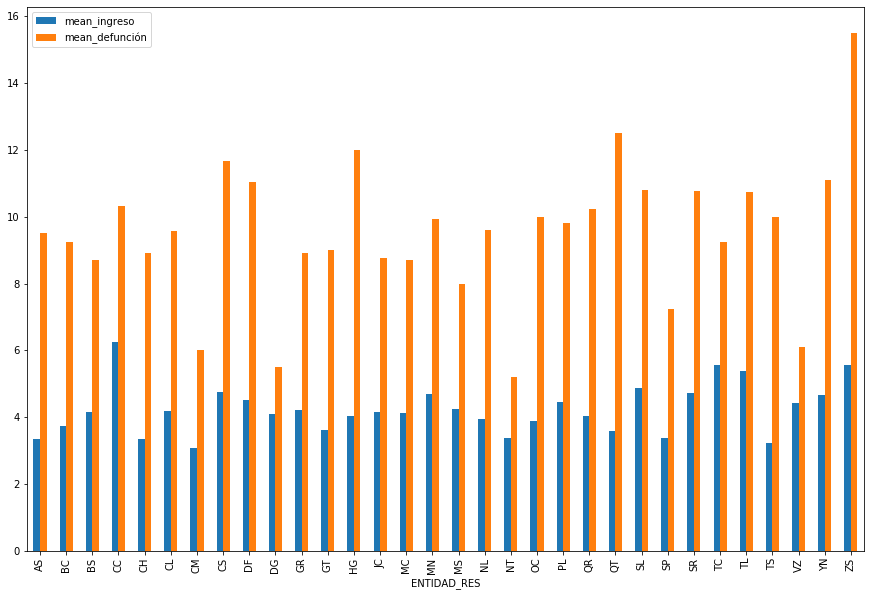

In [10]:
print(dataf.columns)
dataq1 = dataf.query('RESULTADO =="Positivo SARS-CoV-2"')

#sintomas = dataq1.groupby(['ENTIDAD_RES']).sum()['DIAS_SINTOMAS_DEF'].to_frame(name='FECHA_SINTOMAS')
ingreso = dataq1.groupby(['ENTIDAD_RES'])['DIAS_INGRESO_SINTOMAS'].agg([np.mean]) #.agg([np.sum, pd.Series.count, np.mean, np.std])
defunciones = dataq1.groupby(['ENTIDAD_RES'])['DIAS_SINTOMAS_DEF'].agg([np.mean])

ingreso = ingreso.join(defunciones, lsuffix='_ingreso', rsuffix='_defunción')

ingreso.plot(kind='bar', figsize=(15,10))

Index(['ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC',
       'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'STATUS',
       'ENTIDAD_MUNICIPIO_RES', 'DIAS_INGRESO_SINTOMAS', 'DIAS_SINTOMAS_DEF'],
      dtype='object')


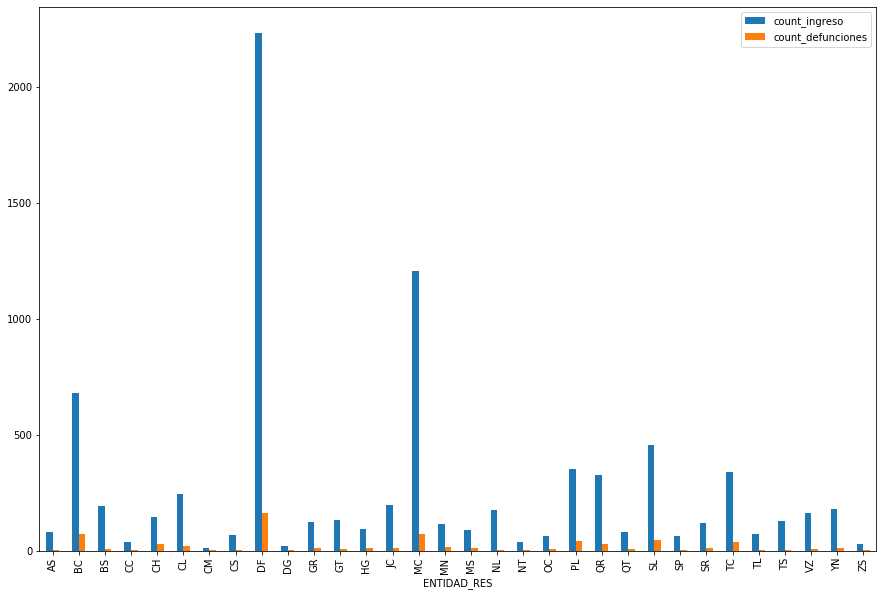

In [11]:
print(dataf.columns)
dataq1 = dataf.query('RESULTADO =="Positivo SARS-CoV-2"')

sintomas = dataq1.groupby(['ENTIDAD_RES'])['FECHA_INGRESO'].agg(['count'])
ingreso = dataq1.groupby(['ENTIDAD_RES'])['FECHA_SINTOMAS'].agg(['count']) #.agg([np.sum, pd.Series.count, np.mean, np.std])
defunciones = dataq1.groupby(['ENTIDAD_RES'])['FECHA_DEF'].agg(['count'])

#sintomas = sintomas.join(ingreso, lsuffix='_ingreso', rsuffix='_sintomas')
ingreso = ingreso.join(defunciones, lsuffix='_ingreso', rsuffix='_defunciones')

ingreso.plot(kind='bar', figsize=(15,10))

Index(['ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC',
       'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'STATUS',
       'ENTIDAD_MUNICIPIO_RES', 'DIAS_INGRESO_SINTOMAS', 'DIAS_SINTOMAS_DEF'],
      dtype='object')
                       count              
TIPO_PACIENTE    AMBULATORIO HOSPITALIZADO
SECTOR STATUS                             
IMSS   FALLECIDO        16.0          90.0
       VIVO            405.0         261.0
ISSSTE FALLECIDO         1.0          17.0
       VIVO             48.0         153.0
PEMEX  FALLECIDO         NaN           2.0


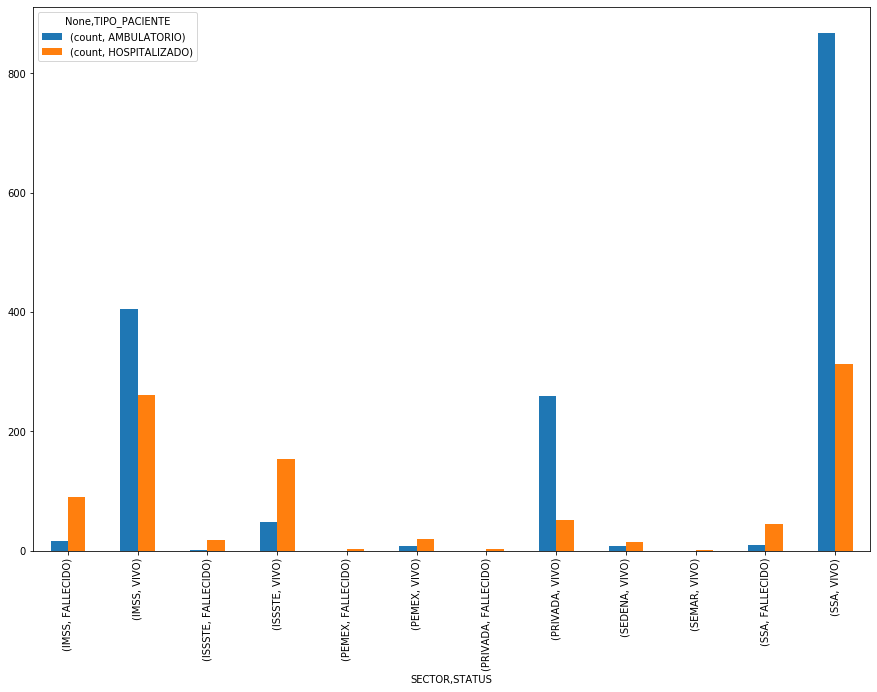

In [24]:
#ingreso = ingreso.join(defunciones, lsuffix='_ingreso', rsuffix='_defunción')
#ingreso.plot(kind='bar', figsize=(15,10))

#ingreso.plot(kind='bar', figsize=(15,10))
#defunciones.plot(kind='bar', figsize=(15,10))

#fechas = fechas_dataFrame.join(fechaSintomas, lsuffix='si', rsuffix='_other')
#fechas = fechas.join(fechaIngreso, lsuffix='_caller', rsuffix='_other')
#fechas = fechas.join(fechadef, lsuffix='_caller', rsuffix='_other')

#fechas = fechas.drop(['Fecha'], axis=1)

#fechas.plot(kind='line', figsize=(15,10))

#print(dataq1[['ENTIDAD_RES','MUNICIPIO_RES','FECHA_SINTOMAS','FECHA_INGRESO','FECHA_DEF']])
#dataq1 = dataq1.groupby(['FECHA_SINTOMAS','ENTIDAD_RES'])['SEXO'].agg(['count']).unstack(1) 
#dataq1 = dataq1.groupby(['FECHA_SINTOMAS','ENTIDAD_RES'])['SEXO'].agg(['count']).unstack(1) 


#dataq1 = dataq1[['FECHA_INGRESO','FECHA_SINTOMAS','FECHA_DEF', 'DIAS_INGRESO_SINTOMAS','DIAS_SINTOMAS_DEF']]
#dataq1.head()

#print(dataq1.head(1))
#dataq1.plot(kind='line', figsize=(15,20))

#dataq1[['DIAS_INGRESO_SINTOMAS','DIAS_SINTOMAS_DEF']]
#dataq1 = dataq1.groupby(['FECHA_SINTOMAS','ENTIDAD_RES'])['SEXO'].agg(['count']).unstack(1)


#print(fechaSintomas)
#print(type(fechas))

#fechasIndex = pd.DatetimeIndex(fechas.values)
#df3=df.set_index(fechasIndex)
#print(type(df3))

#records = df.to_records(index=False)
#result = list(records)
#print(result)
#OUTPUT

print(dataf.columns)
dataq1 = dataf.query('RESULTADO =="Positivo SARS-CoV-2" and ENTIDAD_UM == "DF"')
dataq1 = dataq1[['SECTOR','ENTIDAD_UM','TIPO_PACIENTE','FECHA_INGRESO','FECHA_SINTOMAS','FECHA_DEF','STATUS']]

#dataq1 = dataq1.groupby(['ENTIDAD_RES','SECTOR'])['DIAS_INGRESO_SINTOMAS'].agg(['count']).unstack(1)

dataq1 = dataq1.groupby(['SECTOR','TIPO_PACIENTE','STATUS'])['ENTIDAD_UM'].agg(['count']).unstack(1)


print(dataq1.head())

dataq1.plot(kind='bar', figsize=(15,10))